Work Distribution:

Sofiia Parkhomets (024712322C): Data quality and preparation, Data preprocessing, Conclusions & Recomendations

Angelina Naliuka (024712312B): Apriory Algorythm, Visualization, Conclusions & Recomendations


In [ ]:
!pip install rapidfuzz

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 18.9 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from rapidfuzz import fuzz, process
import re

In [ ]:
df = pd.read_excel("Online Retail.xlsx")

In [ ]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


# **Data Quality and Preparation**

In [ ]:
print(f"Number of records: {df.shape[0]}")

Number of records: 541909


The dataset comes from the https://archive.ics.uci.edu/dataset/352/online+retail. It includes over 541,909 transactions between a UK-based online retail store and its customers across Europe. The data spans from 01/12/2010 to 09/12/2011 and includes invoice numbers, product descriptions, quantity, unit price, customer ID, and country.

In [ ]:
# checking missing values
df.isnull().sum()

,0
InvoiceNo,0
StockCode,0
Description,1454
Quantity,0
InvoiceDate,0
UnitPrice,0
CustomerID,135080
Country,0


In [ ]:
# duplicate rows
df.duplicated().sum()

np.int64(5268)

In [ ]:
# empty or whitespace rows
df_empty = df[df['Description'].str.strip() == ''] == True

In [ ]:
# Quantity = 0 or negative prices
(df['Quantity'] <= 0).sum()

np.int64(10624)

In [ ]:
# UnitPrice = 0 or negative prices
(df['UnitPrice'] <= 0).sum()

np.int64(2517)

In [ ]:
df[['UnitPrice', 'Quantity']].describe()

,UnitPrice,Quantity
count,541909.000000,541909.000000
mean,4.611114,9.552250
std,96.759853,218.081158
min,-11062.060000,-80995.000000
25%,1.250000,1.000000
50%,2.080000,3.000000
75%,4.130000,10.000000
max,38970.000000,80995.000000


In [ ]:
df_with_letters = df[df['InvoiceNo'].str.contains(r'[a-zA-Z]', na=False)]
print(f"Number of canceled orders: {df_with_letters.shape[0]}")
df_with_letters.head(5)

Number of canceled orders: 9291


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527.0,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311.0,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548.0,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom


In [ ]:
descriptions = df['Description'].dropna().astype(str).unique().tolist()

def find_similar_descriptions(description_list, threshold=90):
    checked = set()
    similar_groups = []

    for desc in description_list:
        if desc in checked:
            continue
        # Find most similar strings above the threshold
        matches = process.extract(desc, description_list, scorer=fuzz.token_sort_ratio, limit=None)
        group = [match[0] for match in matches if match[1] >= threshold and match[0] != desc]

        if group:
            similar_groups.append((desc, group))
            checked.update(group)
            checked.add(desc)

    return similar_groups

similar_items = find_similar_descriptions(descriptions, threshold=90)

for base, matches in similar_items:
    print(f"\n'{base}' is similar to:")
    for match in matches:
        print(f"  → {match}")


'POPPY'S PLAYHOUSE BEDROOM ' is similar to:
  → POPPY'S PLAYHOUSE BATHROOM

'HOME BUILDING BLOCK WORD' is similar to:
  → LOVE BUILDING BLOCK WORD

'ALARM CLOCK BAKELIKE RED ' is similar to:
  → ALARM CLOCK BAKELIKE GREEN
  → ALARM CLOCK BAKELIKE ORANGE

' SET 2 TEA TOWELS I LOVE LONDON ' is similar to:
  → SET 2 TEA TOWELS I LOVE LONDON 

'RED HANGING HEART T-LIGHT HOLDER' is similar to:
  → HANGING HEART JAR T-LIGHT HOLDER

'WHITE SPOT RED CERAMIC DRAWER KNOB' is similar to:
  → RED SPOT CERAMIC DRAWER KNOB

'CLEAR DRAWER KNOB ACRYLIC EDWARDIAN' is similar to:
  → BLUE DRAWER KNOB ACRYLIC EDWARDIAN

'GIN + TONIC DIET METAL SIGN' is similar to:
  → GIN AND TONIC DIET METAL SIGN

'3 TIER CAKE TIN GREEN AND CREAM' is similar to:
  → 3 TIER CAKE TIN RED AND CREAM

'NATURAL SLATE HEART CHALKBOARD ' is similar to:
  → NATURAL SLATE CHALKBOARD LARGE 

'FAIRY TALE COTTAGE NIGHTLIGHT' is similar to:
  → FAIRY TALE COTTAGE NIGHT LIGHT

'5 HOOK HANGER MAGIC TOADSTOOL' is similar to:
  → 5 HOOK

# **Problem Statement**
We aim to discover product associations to support sales improvement in the four countries with the highest number of sales.

By revealing localized buying patterns, we can:

1. Identify country-specific product combinations,
2. Compare customer behavior across regions.

# **DATA PREPROCESSING:**

In [ ]:
df_copy = df.copy()

In [ ]:
# find four countries with the highest number of sales.
top_countries = df_copy.groupby('Country')['InvoiceNo'].nunique().sort_values(ascending=False).head(4)

print("Top 4 countries by number of sales:")
print(top_countries.index.tolist())

Top 4 countries by number of sales:
['United Kingdom', 'Germany', 'France', 'EIRE']


In [ ]:
# remove rows with Quantity <= 0 or UnitPrice <= 0
df_copy = df_copy[(df_copy['Quantity'] > 0) & (df_copy['UnitPrice'] > 0)]

In [ ]:
df_copy = df_copy[['InvoiceNo', 'Description', 'Country']]

In [ ]:
# remove rows with missing Description values
df_copy = df_copy.dropna(subset=['Description'])

In [ ]:
# remove rows with empty or whitespace-only descriptions
df_copy = df_copy[df_copy['Description'].str.strip() != '']

In [ ]:
# remove invoice numbers that contain letters
df_copy = df_copy[~df_copy['InvoiceNo'].astype(str).str.contains(r'[a-zA-Z]', na=False)]

In [ ]:
# convert to lowercase
df_copy['Description'] = df_copy['Description'].str.lower()

In [ ]:
# leaves only letters, numbers, spaces
df_copy['Description'] = df_copy['Description'].apply(lambda x: re.sub(r'[^\w\s]', '', x))

In [ ]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Remove English stopwords
df_copy['Description'] = df_copy['Description'].apply(
    lambda x: ' '.join([word for word in x.split() if word not in stop_words])
)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()

# Lemmatize each word
df_copy['Description'] = df_copy['Description'].apply(
    lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()])
)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
# corrections dictionary
corrections = {
    "nightlight": "night light",
    "pannetone": "panettone",
    "s4": "4",
    "cakestand": "cake stand",
    "n0": "no",
    "blackchristmas": "black christmas",
    "coloured": "colour",
    "holderi": "holder",
    "boxfunky": "box funky",
    "cd": "",
    "w": "",
    "gymkhanna": "gymkhana",
    "antoienett": "antoinette",
    "pc": "piece",
    "mistletoe": "miseltoe",
    "meter": "metre",
    "doiley": "doily",
    "la": "",
    "le": "",
    "colouring": "colour",
    "trellistriple": "trellis triple",
    "saftey": "safety",
    "bdraw": "draw",
    "fairy5": "fairy",
    "wsucker": "sucker",
    "orangewhtfuschia": "orangefuschia",
    "jampot": "jam pot",
    "sweeet": "sweet",
    "art": "artonly",
    "jug": "mug",
    "ade": "aid",
    "dof": "",
}

def apply_corrections(text, corrections_dict):
    words = text.split()
    corrected_words = [corrections_dict.get(word, word) for word in words]
    return ' '.join(corrected_words)

df_copy['Description'] = df_copy['Description'].apply(lambda x: apply_corrections(x, corrections))

In [ ]:
# sort words in the description in alphabetical order
df_copy['Description'] = df_copy['Description'].apply(lambda x: ' '.join(sorted(x.split())))

In [ ]:
# Remove 'set' and anything immediately following it (e.g., 'set6', 'set_red') from the Description column
df_copy['Description'] = df_copy['Description'].str.replace(r'\bset\w*\b', '', regex=True).str.strip()

In [ ]:
 # removes extra spaces
 df_copy['Description'] = df_copy['Description'].str.replace(r'\s+', ' ', regex=True).str.strip()

In [ ]:
descriptions = df_copy['Description'].astype(str).unique().tolist()

def find_similar_descriptions(description_list, threshold=90):
    checked = set()
    similar_groups = []

    for desc in description_list:
        if desc in checked:
            continue
        # Find most similar strings above the threshold
        matches = process.extract(desc, description_list, scorer=fuzz.token_sort_ratio, limit=None)
        group = [match[0] for match in matches if match[1] >= threshold and match[0] != desc]

        if group:
            similar_groups.append((desc, group))
            checked.update(group)
            checked.add(desc)

    return similar_groups

similar_items = find_similar_descriptions(descriptions, threshold=90)

for base, matches in similar_items:
    print(f"\n'{base}' is similar to:")
    for match in matches:
        print(f"  → {match}")


'block building home word' is similar to:
  → block building love word

'alarm bakelike clock red' is similar to:
  → alarm bakelike clock green
  → alarm bakelike clock orange

'hanging heart holder red tlight' is similar to:
  → hanging heart holder jar tlight

'ceramic drawer knob red spot white' is similar to:
  → ceramic drawer knob red spot

'acrylic clear drawer edwardian knob' is similar to:
  → acrylic blue drawer edwardian knob

'3 cake cream green tier tin' is similar to:
  → 3 cake cream red tier tin

'chalkboard heart natural slate' is similar to:
  → chalkboard large natural slate

'5 hanger hook magic toadstool' is similar to:
  → 5 hanger hook magic red toadstool

'bin bread diner pink style' is similar to:
  → bin bread diner mint style

'12 pencil skull tall tube' is similar to:
  → 12 pencil skull small tube

'500g bag marble swirly' is similar to:
  → 250g bag marble swirly
  → 125g bag marble swirly

'cover flag pink squarecushion union' is similar to:
  → cover j

In [ ]:
# split cleaned dataset by country
df_uk = df_copy[df_copy['Country'] == 'United Kingdom']
df_germany = df_copy[df_copy['Country'] == 'Germany']
df_france = df_copy[df_copy['Country'] == 'France']
df_eire = df_copy[df_copy['Country'] == 'EIRE']

# **Association Discovery**

In [ ]:
def remove_duplicate_rules(rules):
    """Removes mirrored rules like A→B and B→A (based on itemset content)."""
    seen = set()
    unique_rows = []

    for idx, row in rules.iterrows():
        ant = frozenset(row['antecedents'])
        cons = frozenset(row['consequents'])
        rule_pair = frozenset([ant, cons])

        if rule_pair not in seen:
            seen.add(rule_pair)
            unique_rows.append(row)

    return pd.DataFrame(unique_rows)

In [ ]:
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules
import pandas as pd

def run_apriori(country_df, min_support=0.02, min_confidence=0.5, top_n=10):
    """
    Runs the Apriori algorithm on a single country-specific DataFrame and returns the discovered association rules.

    Parameters:
        country_df (DataFrame): A DataFrame filtered for a single country.
        min_support (float): Minimum support threshold for the Apriori algorithm.
        min_confidence (float): Minimum confidence threshold for rule generation.
        top_n (int): Number of top rules to display, sorted by lift.

    Returns:
        DataFrame: Association rules sorted by lift.
    """
    # Group product descriptions by invoice to form transactions
    transactions = country_df.groupby('InvoiceNo')['Description'].apply(list)

    if len(transactions) < 50:
        print(f"Not enough transactions: {len(transactions)}")
        return None

    # One-hot encode the transaction data
    te = TransactionEncoder()
    te_ary = te.fit(transactions).transform(transactions)
    df_encoded = pd.DataFrame(te_ary, columns=te.columns_)

    # Generate frequent itemsets
    frequent_itemsets = apriori(df_encoded, min_support=min_support, use_colnames=True)

    if frequent_itemsets.empty:
        print("No frequent itemsets found.")
        return None

    # Generate association rules
    rules = association_rules(frequent_itemsets, metric='confidence', min_threshold=min_confidence)

    if rules.empty:
        print("No association rules found.")
        return None

    # Optionally remove mirrored duplicates
    if 'remove_duplicate_rules' in globals():
        rules = remove_duplicate_rules(rules)

    # Sort rules by lift and display the top N
    rules_sorted = rules.sort_values(by='lift', ascending=False)
    print(f"Top {top_n} rules:")
    display(rules_sorted.head(top_n))

    return rules_sorted

In [ ]:
rules_uk = run_apriori(df_uk)

Top 10 rules:


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
51,(christmas heart scandinavian wooden),(christmas scandinavian star wooden),0.028250,0.026585,0.020424,0.722986,27.195754,1.0,0.019673,3.513961,0.991231,0.593548,0.715421,0.745627
72,"(regency rose saucer teacup, green regency sau...",(pink regency saucer teacup),0.038850,0.038961,0.027306,0.702857,18.040000,1.0,0.025792,3.234266,0.982747,0.540659,0.690811,0.701856
71,"(pink regency saucer teacup, regency rose sauc...",(green regency saucer teacup),0.030248,0.051726,0.027306,0.902752,17.452565,1.0,0.025741,9.751119,0.972106,0.499492,0.897448,0.715325
70,"(pink regency saucer teacup, green regency sau...",(regency rose saucer teacup),0.031968,0.053058,0.027306,0.854167,16.098719,1.0,0.025610,6.493316,0.968856,0.473077,0.845995,0.684406
54,(pink regency saucer teacup),(green regency saucer teacup),0.038961,0.051726,0.031968,0.820513,15.862661,1.0,0.029953,5.283241,0.974944,0.544423,0.810722,0.719269
47,(box dolly girl lunch),(box lunch spaceboy),0.038795,0.038906,0.023643,0.609442,15.664661,1.0,0.022134,2.460824,0.973946,0.437372,0.593632,0.608573
29,(bag charlotte woodland),(bag charlotte strawberry),0.037796,0.037352,0.020757,0.549192,14.703340,1.0,0.019345,2.135386,0.968597,0.381633,0.531701,0.552457
60,(pink regency saucer teacup),(regency rose saucer teacup),0.038961,0.053058,0.030248,0.776353,14.632148,1.0,0.028180,4.234097,0.969427,0.489668,0.763822,0.673218
49,(cup gardener kneeling pad tea),(calm gardener keep kneeling pad),0.041625,0.049839,0.030026,0.721333,14.473256,1.0,0.027951,3.409668,0.971339,0.488708,0.706716,0.661892
24,(bag charlotte pink polkadot),(bag charlotte strawberry),0.037352,0.037352,0.020091,0.537890,14.400747,1.0,0.018696,2.083159,0.966666,0.367886,0.519960,0.537890


In [ ]:
rules_germany = run_apriori(df_germany)

Top 10 rules:


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
195,(childrens cup dolly girl),(bowl childrens dolly girl),0.024070,0.026258,0.024070,1.000000,38.083333,1.0,0.023438,inf,0.997758,0.916667,1.000000,0.958333
654,"(childrens cup dolly girl, postage)",(bowl childrens dolly girl),0.021882,0.026258,0.021882,1.000000,38.083333,1.0,0.021307,inf,0.995526,0.833333,1.000000,0.916667
656,"(postage, bowl childrens dolly girl)",(childrens cup dolly girl),0.024070,0.024070,0.021882,0.909091,37.768595,1.0,0.021302,10.735230,0.997534,0.833333,0.906849,0.909091
142,(beaker pink spot vintage),(beaker blue spot vintage),0.024070,0.030635,0.024070,1.000000,32.642857,1.0,0.023333,inf,0.993274,0.785714,1.000000,0.892857
948,"(ceramic drawer knob red stripe, ceramic drawe...",(ceramic drawer knob red spot),0.028446,0.030635,0.021882,0.769231,25.109890,1.0,0.021010,4.200584,0.988288,0.588235,0.761938,0.741758
622,"(ceramic drawer knob red stripe, ceramic drawe...",(blue ceramic drawer knob stripe),0.032823,0.028446,0.021882,0.666667,23.435897,1.0,0.020948,2.914661,0.989819,0.555556,0.656907,0.717949
188,(owl pink soft toy),(blue owl soft toy),0.028446,0.032823,0.021882,0.769231,23.435897,1.0,0.020948,4.191101,0.985360,0.555556,0.761399,0.717949
144,(beaker blue spot vintage),(beaker red spot vintage),0.030635,0.030635,0.021882,0.714286,23.316327,1.0,0.020943,3.392779,0.987359,0.555556,0.705256,0.714286
953,"(ceramic drawer knob red stripe, postage)","(ceramic drawer knob red spot white, ceramic d...",0.037199,0.026258,0.021882,0.588235,22.401961,1.0,0.020905,2.364802,0.992273,0.526316,0.577132,0.710784
604,"(blue ceramic drawer knob spot, postage)",(blue ceramic drawer knob spot white),0.028446,0.035011,0.021882,0.769231,21.971154,1.0,0.020886,4.181619,0.982432,0.526316,0.760858,0.697115


In [ ]:
rules_france = run_apriori(df_france)

Top 10 rules:


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
3009,"(alarm bakelike clock green, paper plate red s...","(alarm bakelike clock pink, cup paper red spotty)",0.020408,0.025510,0.020408,1.000000,39.200000,1.0,0.019888,inf,0.994792,0.800000,1.000000,0.900000
3010,"(alarm bakelike clock green, cup paper red spo...","(paper plate red spotty, alarm bakelike clock ...",0.022959,0.022959,0.020408,0.888889,38.716049,1.0,0.019881,8.793367,0.997063,0.800000,0.886278,0.888889
5381,"(bowl childrens spaceboy, childrens cup dolly ...","(bowl childrens dolly girl, childrens cup spac...",0.025510,0.028061,0.025510,1.000000,35.636364,1.0,0.024794,inf,0.997382,0.909091,1.000000,0.954545
763,"(acapulco mat recycled red, acapulco mat recyc...",(acapulco lavender mat recycled),0.022959,0.025510,0.020408,0.888889,34.844444,1.0,0.019822,8.770408,0.994125,0.727273,0.885980,0.844444
770,"(acapulco mat recycled red, postage)",(acapulco lavender mat recycled),0.022959,0.025510,0.020408,0.888889,34.844444,1.0,0.019822,8.770408,0.994125,0.727273,0.885980,0.844444
4056,"(bowl childrens spaceboy, childrens cup dolly ...",(childrens cup spaceboy),0.025510,0.033163,0.025510,1.000000,30.153846,1.0,0.024664,inf,0.992147,0.769231,1.000000,0.884615
5385,"(bowl childrens dolly girl, postage, childrens...","(bowl childrens spaceboy, childrens cup dolly ...",0.025510,0.033163,0.025510,1.000000,30.153846,1.0,0.024664,inf,0.992147,0.769231,1.000000,0.884615
5375,"(bowl childrens spaceboy, childrens cup dolly ...",(childrens cup spaceboy),0.025510,0.033163,0.025510,1.000000,30.153846,1.0,0.024664,inf,0.992147,0.769231,1.000000,0.884615
4007,"(bowl childrens spaceboy, childrens cup dolly ...","(childrens cup spaceboy, bowl childrens dolly ...",0.033163,0.028061,0.028061,0.846154,30.153846,1.0,0.027131,6.317602,1.000000,0.846154,0.841712,0.923077
90,(acapulco mat recycled turquoise),(acapulco lavender mat recycled),0.030612,0.025510,0.022959,0.750000,29.400000,1.0,0.022178,3.897959,0.996491,0.692308,0.743455,0.825000


In [ ]:
rules_eire = run_apriori(df_eire)

Top 10 rules:


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
8316,"(60 cake case design pantry, plate regency ros...","(pink plate regency tea, 60 cake case pack pai...",0.027778,0.020833,0.020833,0.750000,36.000000,1.0,0.020255,3.916667,1.000000,0.750000,0.744681,0.875000
8312,"(60 cake case design pantry, pink plate regenc...","(60 cake case pack paisley pink, green plate r...",0.024306,0.024306,0.020833,0.857143,35.265306,1.0,0.020243,6.829861,0.995848,0.750000,0.853584,0.857143
2801,"(60 cake case design pantry, pink plate regenc...","(60 cake case pack paisley pink, green plate r...",0.027778,0.024306,0.020833,0.750000,30.857143,1.0,0.020158,3.902778,0.995238,0.666667,0.743772,0.803571
121,(birthday blue bunting happy),(birthday bunting happy pink),0.027778,0.024306,0.020833,0.750000,30.857143,1.0,0.020158,3.902778,0.995238,0.666667,0.743772,0.803571
8319,"(60 cake case pack paisley pink, plate regency...","(60 cake case design pantry, pink plate regenc...",0.024306,0.027778,0.020833,0.857143,30.857143,1.0,0.020158,6.805556,0.991696,0.666667,0.853061,0.803571
170,(butterfly cushion feltcraft),(cushion feltcraft rabbit),0.027778,0.024306,0.020833,0.750000,30.857143,1.0,0.020158,3.902778,0.995238,0.666667,0.743772,0.803571
2821,"(60 cake case design pantry, plate regency ros...","(pink plate regency tea, 60 cake case pack pai...",0.034722,0.020833,0.020833,0.600000,28.800000,1.0,0.020110,2.447917,1.000000,0.600000,0.591489,0.800000
2803,"(60 cake case design pantry, green plate regen...","(pink plate regency tea, 60 cake case pack pai...",0.034722,0.020833,0.020833,0.600000,28.800000,1.0,0.020110,2.447917,1.000000,0.600000,0.591489,0.800000
25531,"(regency rose teapot, 3 cake regency stand tie...","(regency sugar tongs, bowl green regency sugar...",0.034722,0.020833,0.020833,0.600000,28.800000,1.0,0.020110,2.447917,1.000000,0.600000,0.591489,0.800000
17205,"(regency rose teapot, plate regency rose tea, ...","(regency sugar tongs, 3 cake regency stand tie...",0.034722,0.020833,0.020833,0.600000,28.800000,1.0,0.020110,2.447917,1.000000,0.600000,0.591489,0.800000


# **Visualization**

In [ ]:
def plot_heatmap(rules, top_n=10, max_len=30):
    import seaborn as sns
    import matplotlib.pyplot as plt

    # select top-N rules by lift
    top_rules = rules.sort_values(by='lift', ascending=False).head(top_n).copy()

    def format_items(items):
        items = sorted(items)
        label = ', '.join(items)
        return label[:max_len] + ('...' if len(label) > max_len else '')

    top_rules['antecedents_str'] = top_rules['antecedents'].apply(format_items)
    top_rules['consequents_str'] = top_rules['consequents'].apply(format_items)

    # handle duplicates by keeping the max lift per (antecedent, consequent) pair
    pivot = (
        top_rules.groupby(['antecedents_str', 'consequents_str'])['lift']
        .max()
        .unstack()
    )

    pivot = pivot.loc[pivot.mean(axis=1).sort_values(ascending=False).index]
    pivot = pivot[pivot.mean().sort_values(ascending=False).index]

    plt.figure(figsize=(12, 8))
    sns.heatmap(pivot, annot=True, fmt=".2f", cmap="YlGnBu", cbar_kws={'label': 'Lift'},
                linewidths=0.5, linecolor='gray')

    plt.title("Heatmap of Top Association Rules (sorted by Lift)", fontsize=14)
    plt.xlabel("Consequents")
    plt.ylabel("Antecedents")
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

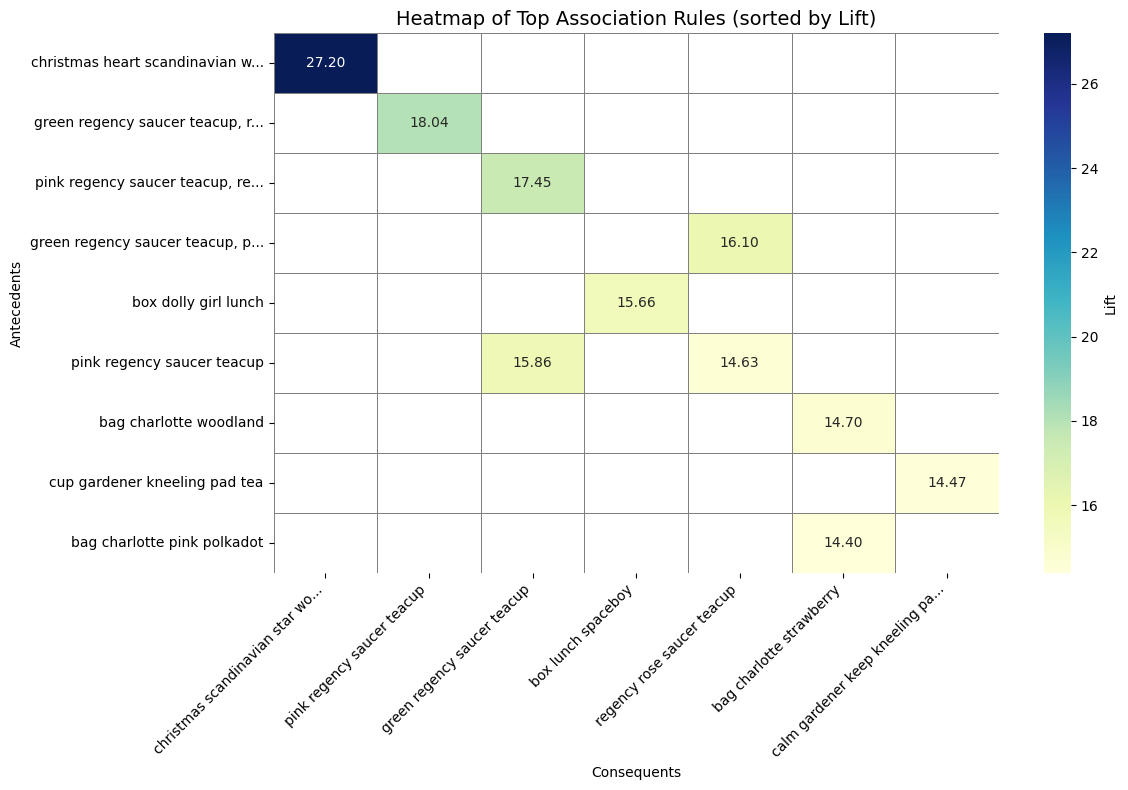

In [ ]:
plot_heatmap(rules_uk)

In [ ]:
for idx, row in rules_uk.sort_values(by='lift', ascending=False).head(10).iterrows():
    antecedents = ', '.join(sorted(row['antecedents']))
    consequents = ', '.join(sorted(row['consequents']))
    print(f"Rule {idx}: {antecedents} → {consequents}, Lift = {row['lift']:.2f}")

# Rule: christmas heart scandinavian wooden → christmas scandinavian star wooden Lift: 27.20
# This very high lift indicates a strong association: customers who buy the "christmas heart scandinavian wooden" item are highly likely to also buy the "christmas scandinavian star wooden" item.
# Likely part of a themed set or decoration line.

# Rule: green regency saucer teacup, regency rose saucer teacup → pink regency saucer teacup Lift: 18.04
# If a customer purchases both green and rose teacup saucers, they are very likely to buy the pink one too.
# This cold indicates collection-style buying behavior.

Rule 51: christmas heart scandinavian wooden → christmas scandinavian star wooden, Lift = 27.20
Rule 72: green regency saucer teacup, regency rose saucer teacup → pink regency saucer teacup, Lift = 18.04
Rule 71: pink regency saucer teacup, regency rose saucer teacup → green regency saucer teacup, Lift = 17.45
Rule 70: green regency saucer teacup, pink regency saucer teacup → regency rose saucer teacup, Lift = 16.10
Rule 54: pink regency saucer teacup → green regency saucer teacup, Lift = 15.86
Rule 47: box dolly girl lunch → box lunch spaceboy, Lift = 15.66
Rule 29: bag charlotte woodland → bag charlotte strawberry, Lift = 14.70
Rule 60: pink regency saucer teacup → regency rose saucer teacup, Lift = 14.63
Rule 49: cup gardener kneeling pad tea → calm gardener keep kneeling pad, Lift = 14.47
Rule 24: bag charlotte pink polkadot → bag charlotte strawberry, Lift = 14.40


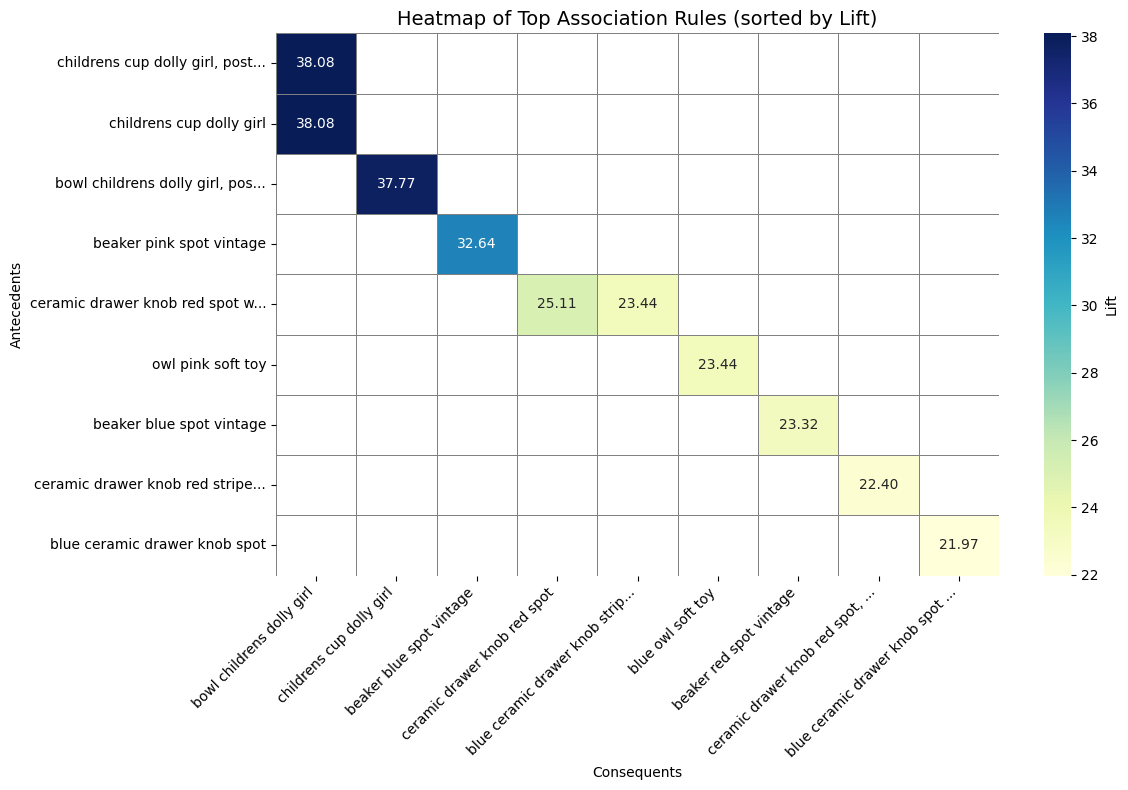

In [ ]:
plot_heatmap(rules_germany)

In [ ]:
for idx, row in rules_germany.sort_values(by='lift', ascending=False).head(10).iterrows():
    antecedents = ', '.join(sorted(row['antecedents']))
    consequents = ', '.join(sorted(row['consequents']))
    print(f"Rule {idx}: {antecedents} → {consequents}, Lift = {row['lift']:.2f}")

# Rule: “childrens cup dolly girl” → “bowl childrens dolly girl”
# This suggests a strong pattern where customers who buy the "childrens cup dolly girl" almost always also purchase the matching bowl.
# Lift: 38.08 — extremely strong co-purchase relationship.

# Rule: “owl pink soft toy” → “blue owl soft toy”
# Customers who buy one version of the owl toy are very likely to buy the other color too.

Rule 195: childrens cup dolly girl → bowl childrens dolly girl, Lift = 38.08
Rule 654: childrens cup dolly girl, postage → bowl childrens dolly girl, Lift = 38.08
Rule 656: bowl childrens dolly girl, postage → childrens cup dolly girl, Lift = 37.77
Rule 142: beaker pink spot vintage → beaker blue spot vintage, Lift = 32.64
Rule 948: ceramic drawer knob red spot white, ceramic drawer knob red stripe, postage → ceramic drawer knob red spot, Lift = 25.11
Rule 622: ceramic drawer knob red spot white, ceramic drawer knob red stripe → blue ceramic drawer knob stripe, Lift = 23.44
Rule 188: owl pink soft toy → blue owl soft toy, Lift = 23.44
Rule 144: beaker blue spot vintage → beaker red spot vintage, Lift = 23.32
Rule 953: ceramic drawer knob red stripe, postage → ceramic drawer knob red spot, ceramic drawer knob red spot white, Lift = 22.40
Rule 168: blue ceramic drawer knob spot → blue ceramic drawer knob spot white, Lift = 21.97


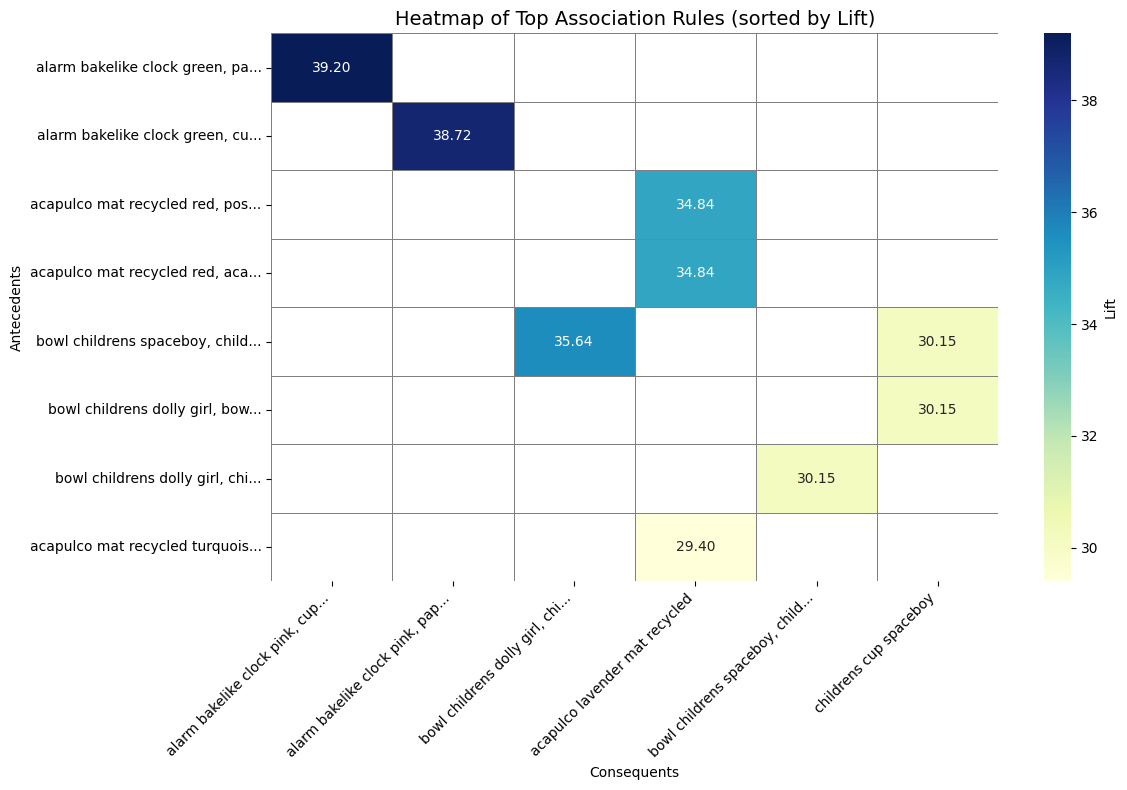

In [ ]:
plot_heatmap(rules_france)

In [ ]:
for idx, row in rules_france.sort_values(by='lift', ascending=False).head(10).iterrows():
    antecedents = ', '.join(sorted(row['antecedents']))
    consequents = ', '.join(sorted(row['consequents']))
    print(f"Rule {idx}: {antecedents} → {consequents}, Lift = {row['lift']:.2f}")

# “acapulco mat recycled red, acapulco mat recycled turquoise” → “acapulco lavender mat recycled”
# Customers who purchase red and turquoise recycled Acapulco mats often also buy the lavender variant.
# Lift: 34.84 – a very strong association, indicating a common preference for collecting matching color variants from the same product line.

Rule 3009: alarm bakelike clock green, paper plate red spotty → alarm bakelike clock pink, cup paper red spotty, Lift = 39.20
Rule 3010: alarm bakelike clock green, cup paper red spotty → alarm bakelike clock pink, paper plate red spotty, Lift = 38.72
Rule 5381: bowl childrens spaceboy, childrens cup dolly girl, postage → bowl childrens dolly girl, childrens cup spaceboy, Lift = 35.64
Rule 770: acapulco mat recycled red, postage → acapulco lavender mat recycled, Lift = 34.84
Rule 763: acapulco mat recycled red, acapulco mat recycled turquoise → acapulco lavender mat recycled, Lift = 34.84
Rule 5375: bowl childrens dolly girl, bowl childrens spaceboy, childrens cup dolly girl, postage → childrens cup spaceboy, Lift = 30.15
Rule 4056: bowl childrens spaceboy, childrens cup dolly girl, postage → childrens cup spaceboy, Lift = 30.15
Rule 4007: bowl childrens spaceboy, childrens cup dolly girl → bowl childrens dolly girl, childrens cup spaceboy, Lift = 30.15
Rule 5385: bowl childrens dolly 

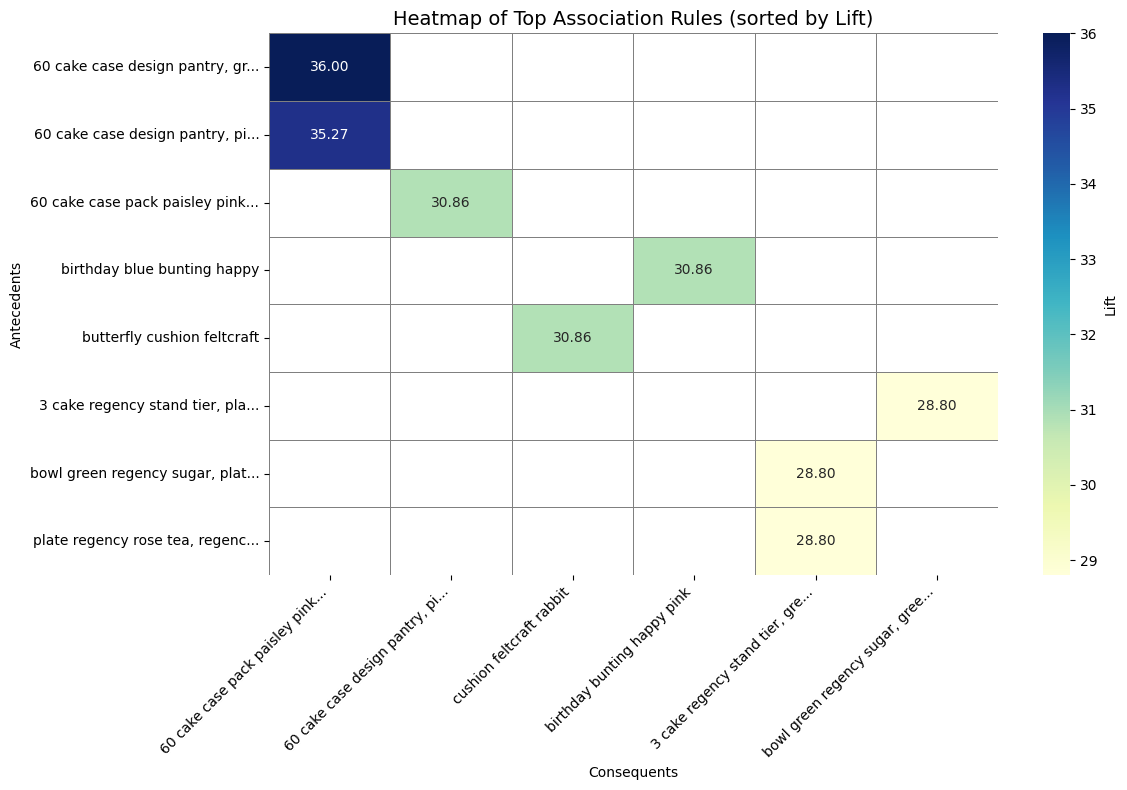

In [ ]:
plot_heatmap(rules_eire)

In [ ]:
for idx, row in rules_eire.sort_values(by='lift', ascending=False).head(10).iterrows():
    antecedents = ', '.join(sorted(row['antecedents']))
    consequents = ', '.join(sorted(row['consequents']))
    print(f"Rule {idx}: {antecedents} → {consequents}, Lift = {row['lift']:.2f}")

# Rule: “birthday blue bunting happy” → “birthday bunting happy pink”
# Customers who buy the blue version of the “birthday bunting happy” decoration are also likely to purchase the pink version,
# suggesting a tendency to buy multiple color variants for event decoration.
# Lift: 30.86 – a very strong association indicating complementary or themed purchasing behavior.

Rule 8316: 60 cake case design pantry, green plate regency tea, plate regency rose tea → 60 cake case pack paisley pink, pink plate regency tea, Lift = 36.00
Rule 8312: 60 cake case design pantry, pink plate regency tea, plate regency rose tea → 60 cake case pack paisley pink, green plate regency tea, Lift = 35.27
Rule 121: birthday blue bunting happy → birthday bunting happy pink, Lift = 30.86
Rule 8319: 60 cake case pack paisley pink, green plate regency tea, plate regency rose tea → 60 cake case design pantry, pink plate regency tea, Lift = 30.86
Rule 2801: 60 cake case design pantry, pink plate regency tea → 60 cake case pack paisley pink, green plate regency tea, Lift = 30.86
Rule 170: butterfly cushion feltcraft → cushion feltcraft rabbit, Lift = 30.86
Rule 25531: 3 cake regency stand tier, plate regency rose tea, regency rose saucer teacup, regency rose teapot → bowl green regency sugar, green plate regency tea, regency sugar tongs, Lift = 28.80
Rule 2803: 60 cake case design pa

# **Conclusion**

In this project, we applied the Apriori algorithm to transactional data from the top four countries by sales: United Kingdom, Germany, France, and Ireland. The objective was to uncover country-specific product associations that can support marketing and sales strategies.

The analysis revealed strong and meaningful association rules, often highlighting complementary or thematically related items (e.g., similar product styles, color variants, or coordinated sets). These rules vary between countries, reflecting localized customer preferences and behaviors. For example, UK customers showed patterns around themed event items, while German customers often purchased matching ceramics.

# **Satisfaction & Reflections**

We are satisfied with the overall results of the project and the knowledge gained throughout the analysis. The process allowed us to apply data preprocessing techniques and the Apriori algorithm meaningfully, revealing insightful product associations across different countries.

However, the dataset itself presented significant challenges. It contained numerous issues, including missing values, inconsistent formatting, and frequent spelling errors in product descriptions. These required extensive preprocessing efforts to clean and normalize the data before any meaningful analysis could be performed.

We suggest dividing the transactions into two types: successful and cancelled. This would help make the analysis more accurate.

We also recommend using basic validation during data entry.

For example, correcting spelling mistakes, following a consistent format, clearly marking the status of each transaction, and not allowing rows with missing Customer ID or Description.